### Reading the MNIST dataset

In [1]:
import numpy as np
#binary and fastly moving data
import pickle
#getting everything that's in a directory - files and dir
from os import listdir
from os.path import isfile, join
#show images
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
abs_path = r"C:/Users/lukar/Desktop/c_cpp_projects/CPP/projects/matrix/Python/MNIST/"

In [3]:
dir_files = [f for f in listdir(abs_path) if isfile(join(abs_path, f))]

In [4]:
dir_files

['mnist_test.csv', 'mnist_train.csv', 'pickled_mnist.pkl', 'Untitled.ipynb']

In [5]:
def numpy_load(path, file_name):
    """
    load data with numpy
    """
    return np.loadtxt(path + file_name, delimiter = ",")

training_data = numpy_load(abs_path, dir_files[1])
test_data = numpy_load(abs_path, dir_files[0])

#separating the data
train_imgs = np.asfarray(training_data[:, 1:])
test_imgs = np.asfarray(test_data[:, 1:])
train_labels = np.asfarray(training_data[:, :1])
test_labels = np.asfarray(test_data[:, :1])

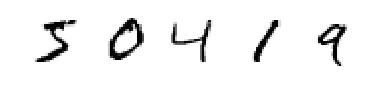

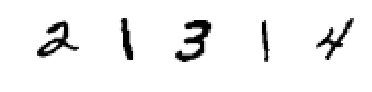

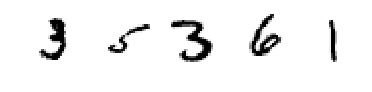

In [6]:
m = 3; n = 5

counter = 0
for i in range(m):
    for _ in range(n):
        plt.subplot(m, n, counter+1)
        plt.imshow(train_imgs[counter, :].reshape(28, 28), cmap="Greys")
        #plt.title(train_labels[counter, 0])
        plt.axis("off")
        counter += 1
    if i % 1 == 0:#plot by batch
        plt.plot()
        plt.show()
#plot the rest
#plt.plot()
#plt.show()

In [288]:
#one_hot = np.eye(10)
#train_labels_one_hot = np.zeros((train_imgs.shape[0], 10))
#test_labels_one_hot = np.zeros((test_imgs.shape[0], 10))

def get_one_hot_data(data):
    array_oh = np.zeros((data.shape[0], 10))
    one_hot = np.eye(10)
    for index, val in enumerate(data):
        array_oh[index, :] = one_hot[int(val), :]
    return array_oh
train_oh = get_one_hot_data(train_labels)
test_oh = get_one_hot_data(test_labels)

def normalize_data(data_:np.ndarray):
    """ normalized_data = (data_i - µ) / sigma 
        we are expecting ONE LINE VECTOR at a time """
    data = data_.copy()
    N = len(data)
    normalized_data = np.zeros_like(data)
    mean = 1 / N * np.sum(data[np.newaxis, :], axis=1)
    sigma = np.sqrt(1 / N * sum([(val - mean)**2 for val in data]))
    print("sigma: ", sigma)
    for index, val in enumerate(data):
        normalized_data[index] = (val - mean) / (sigma+1e-8)
    return normalized_data

def normalize_image_without_zeros(data_:np.ndarray):
    """ in this function, we get rid of useless information to normalize data
        I assume that pixel values that are not digits should remain unchanged
        Thus: zeros remain zeros as we dont want it to bring more information """
    data = data_.copy()
    # we get rid of zeros, we need to store index
    data = [(index, digit) for index, digit in enumerate(data) if digit != 0]
    data_indices, data_values = zip(*data)
    data_indices, data_values = list(data_indices), list(data_values)
    N = len(data)
    #normalized data array dims will be like the original
    normalized_data = np.zeros((1, len(data_)))
    mean = 1 / N * sum(data_values)
    sigma = np.sqrt(1 / N * sum([(val - mean)**2 for val in data_values]))
    for index, val in zip(data_indices, data_values):
        assert(val == data_[index])
        normalized_data[0, index] = (val - mean) / (sigma+1e-8)
    return normalized_data

def normalize_data_without_zeros(data:np.ndarray):
    N = data.shape[0]
    normalized_data = data.copy()
    for index, image in enumerate(normalized_data):
        normalized_data[index, :] = normalize_image_without_zeros(image)
        if index % round(0.1*N) == 0 or index == N-1:
                print("%d / %d" %(index+1, N), end='\r')
    print("\n")
    return normalized_data

train_imgs_normalized = normalize_data_without_zeros(train_imgs)
test_imgs_normalized = normalize_data_without_zeros(test_imgs)
#plt.imshow(aaa.reshape(28, 28))
#plt.show()

60000 / 60000

10000 / 10000



In [298]:
def write_cpp_data(data, file_name):
    lines = data.shape[0]
    with open("cpp_data/"+file_name, 'w') as f:
        for i, data_line in enumerate(data):
            #f.write("\t".join(data_line))
            #if i == 4: break
            COUNTER = 0
            for element in data_line:
                f.write('%f' % (element))
                f.write("\t")
            f.write("\n")
            
            #prints loading state each 10%
            if i % round(0.1*lines) == 0 or i == lines-1:
                print("%d / %d" %(i+1, lines), end='\r')
    print("\n")

#write_cpp_data(train_imgs, "train_data_imgs.txt")
#write_cpp_data(test_imgs, "test_data_imgs.txt")
"""writes .txt data for cpp DL framework"""
#write_cpp_data(train_oh, "train_labels_oh.txt")
#write_cpp_data(test_oh, "test_labels_oh.txt")

abs_path = r"C:/Users/lukar/Desktop/c_cpp_projects/CPP/projects/matrix/Python/MNIST/cpp_data/normalized_without_zeros/"
dir_files = [f for f in listdir(abs_path) if isfile(join(abs_path, f))]

if not dir_files:
    write_cpp_data(train_imgs_normalized, "normalized_without_zeros/train_data_imgs.txt")
    write_cpp_data(test_imgs_normalized, "normalized_without_zeros/test_data_imgs.txt")
    #writes .txt data for cpp DL framework
    write_cpp_data(train_oh, "normalized_without_zeros/train_labels_oh.txt")
    write_cpp_data(test_oh, "normalized_without_zeros/test_labels_oh.txt")


60000 / 60000

10000 / 10000

60000 / 60000

10000 / 10000



In [7]:
a = {1: 12, 2: 10}
for c in a.values(): print(c)

12
10


IDEA: "friendly network" for image recognition
instead of an adversarial network, a friendly network localizes pixels
of an image that are not relevant to the class of objects we want to localize, based on the predictions of the main network(it simply has to take the opposite of the predictions).
The less the set of pixels is relevant to the area we want to recognize,
the more it will be shrinked towards zero during preprocessing.
This might be a handfull algorithm for online training because it should
significantly reduce the noize. But we need to figure out a way to reduce
computational cost as we d like it to run on online systems.

More practically, we could apply a convolution filter with a dynamic sigma
that would slide across the image. The less relevant the data passing by the 
frame of the filter, the bigger sigma. The more relevant the data, the more
information from the corresponding data will be allowed to pass through the network

The friendly network would be trained by evaluating the score of the main network on the test dataset. The friendly network could be a population of network, with a fitness score for each network, in a "one for all all for one fashion". 
1) Each network filters the data and tries to let the relevant data unchanged. 2) The main network trains itself based on the filtered data
3) The networks that output the filtered data that result in the best score on the test set, when being computed by the main network, should get the best score

OR

Maybe there is no need to create a population and do it genetically and it is possible to modelize a cost function: based on the "relevant location of data from the friend" - "main network prediction"